In [55]:
!pip install category_encoders


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [56]:
import requests
import zipfile
import io
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def descargar_y_descomprimir(url, carpeta_destino="datos"):
    # Crear carpeta si no existe
    os.makedirs(carpeta_destino, exist_ok=True)

    # Descargar archivo
    print("Descargando archivo...")
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise Exception(f"Error al descargar archivo: {response.status_code}")

    # Descomprimir desde memoria
    print("Descomprimiendo archivo...")
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(carpeta_destino)

    print(f"Archivo descargado y extraído en '{carpeta_destino}'")

# Ejemplo de uso
# moviews
#url = "https://www.kaggle.com/api/v1/datasets/download/sufyan145/netflix-movies-and-shows-imdb-scores"
# letterbox
url = "https://www.kaggle.com/api/v1/datasets/download/sahilislam007/letterbox-movie-classification-dataset"
descargar_y_descomprimir(url)

Descargando archivo...
Descomprimiendo archivo...
Archivo descargado y extraído en 'datos'


PENSAR:

Nuestro target es calcular el rating promedio de una peliculo o serie a partir de los siguientes datos:
- Director, Genres, Watches, Original_language, Runtime, Studios

Los datos que no podemos usar son:
- Likes, lowest, medium, highest, Total_ratings


Pensar si podemos plantear que Watches es un dato para usar o no. Porque si es para una persona que quiere saber a priori si va a tener rating o no, no nos sirve.

Otro dato que podemos aportar con watches es hacer matriz Gausseana.

Pensando en klustering podemos agregupar personas/peliculas por las clase y ver si resulta por ejemplo personas que le gustan peliculas de culto.

Similar a un sistema de recomendación porque si te gusta una pelicula  te tiene que gustar la del mismo kluster.

In [57]:
import pandas as pd
import os

# List files in the current directory to find the extracted data file
folder_path = "datos"

if os.path.exists(folder_path):
    files_in_folder = os.listdir(folder_path)
print("Files in the current directory:", files_in_folder)

# Assuming the data is in a CSV file, find the first one
csv_file = None
for file in files_in_folder:
    if file.endswith('.csv'):
        csv_file = file
        break

if csv_file:
    print(f"Loading data from: {folder_path}/{csv_file}")
    # Load the data into a pandas DataFrame
    df = pd.read_csv(f"{folder_path}/{csv_file}")

    # Display the first few rows of the DataFrame
    display(df.head())
else:
    print("No CSV file found in the extracted contents.")

Files in the current directory: ['Letterbox Movie Classification Dataset.csv']
Loading data from: datos/Letterbox Movie Classification Dataset.csv


,Unnamed: 0,Film_title,Director,Average_rating,Genres,Runtime,Original_language,Description,Studios,Watches,List_appearances,Likes,Fans,Lowest★,Medium★★★,Highest★★★★★,Total_ratings
0,0,The Fan,Eckhart Schmidt,3.57,"['Horror', 'Drama']",92.0,German,The hero-worship that Simone has for a pop sin...,['Barbara Moorse Workshop'],12841,11032,3763,79,129,1660,714,9042
1,1,Mad Max: Fury Road,George Miller,4.18,"['Adventure', 'Science Fiction', 'Action']",121.0,English,An apocalyptic story set in the furthest reach...,"['Warner Bros. Pictures', 'Village Roadshow Pi...",2488721,331681,927538,38000,12530,158356,511140,1682389
2,2,Suspiria,Dario Argento,3.93,['Horror'],99.0,English,An American newcomer to a prestigious German b...,['Seda Spettacoli'],618171,220094,219548,13000,2814,53427,88628,443757
3,3,Lost in Translation,Sofia Coppola,3.79,"['Drama', 'Comedy', 'Romance']",102.0,English,"Two lost souls visiting Tokyo -- the young, ne...","['American Zoetrope', 'Elemental Films']",1596190,254180,493248,38000,15167,155110,193717,1076949
4,4,Akira,Katsuhiro Otomo,4.28,"['Animation', 'Action', 'Science Fiction']",124.0,Japanese,A secret military project endangers Neo-Tokyo ...,"['MBS', 'Sumitomo Corporation', 'TOHO', 'Studi...",873068,175586,341567,21000,1822,40850,196532,600721


Elimos como variable target la columna Average_rating, que muestra el puntaje promedio que la gente le da a cada película o serie. Es un valor **continuo** que resume de forma simple qué tan bien recibida fue una película, y nos va a permitir entrenar un **modelo de regresión** para predecir ese valor usando datos como el género, la duración, el idioma, el estudio y su popularidad.

Se elimina la columna Unnamed: 0

In [110]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [58]:
# Obtenemos la cardinalidad de cada columna
cardinalidad = df.nunique().sort_values(ascending=False)

print("Cardinalidad de cada variable:")
print(cardinalidad)

# Cantidad de valores nulos por columna
nulos = df.isnull().sum()

print("Cantidad de valores nulos por variable:")
print(nulos)

Cardinalidad de cada variable:
Unnamed: 0           10000
Description           9963
Film_title            9665
Watches               8794
Total_ratings         8338
Studios               8016
List_appearances      7887
Likes                 6741
Medium★★★             6370
Director              4762
Highest★★★★★          4699
Lowest★               3086
Genres                2397
Fans                   963
Average_rating         327
Runtime                301
Original_language       57
dtype: int64
Cantidad de valores nulos por variable:
Unnamed: 0           0
Film_title           0
Director             0
Average_rating       0
Genres               0
Runtime              0
Original_language    0
Description          0
Studios              0
Watches              0
List_appearances     0
Likes                0
Fans                 0
Lowest★              0
Medium★★★            0
Highest★★★★★         0
Total_ratings        0
dtype: int64


## Cardinalidad:
### Variables con cardinalidad muy alta:

Unnamed 0: (10000): probablemente es un índice único, no es útil como variable.

Description (9963) y Film_title (9665): casi todos distintos, como es de esperar.

Watches (8794), Total_ratings (8338), Studios (8016), List_appearances (7887), Likes (6741), Medium★★★ (6370), Director (4762), Highest★★★★★ (4699): también alta variedad, indican datos numéricos o variables con mucha diversidad (por ejemplo, muchos estudios distintos, directores, etc.).

### Variables con cardinalidad media:

Lowest★ (3086), Genres (2397): géneros tienen menos variedad, pero sigue siendo mucho, considerando que es una lista de los géneros de la película.

Fans (963), Average_rating (327), Runtime (301): Runtime es la duración en minutos, con 301 valores únicos parece plausible (rango de duraciones).

### Varuables con cardinalidad baja:

Original_language (57): Se va analizar mas en profundidad para ver si se puede transformar con OneHotEncoding o TargetEncoding.

Vemos que no hay valores nulos en ninguna variable. En principio, no tenemos que hacer niguna imputación de nulos.

In [59]:
a = df[df['Film_title'].str.contains('Hercules', case=False, na=False)]
a.head(3)

,Unnamed: 0,Film_title,Director,Average_rating,Genres,Runtime,Original_language,Description,Studios,Watches,List_appearances,Likes,Fans,Lowest★,Medium★★★,Highest★★★★★,Total_ratings
173,173,Hercules,"Ron Clements, John Musker",3.82,"['Animation', 'Adventure', 'Romance', 'Comedy'...",93.0,English,"Bestowed with superhuman strength, a young mor...","['Walt Disney Pictures', 'Walt Disney Feature ...",1318587,115062,291974,6200,3188,107615,115996,627632
442,442,Hercules,Luigi Cozzi,2.65,"['Fantasy', 'Action', 'Adventure']",98.0,English,"Hercules, a semi-divine being, squares off aga...","['Golan-Globus Productions', 'Cannon Italia Sr...",5221,3625,884,7,322,721,122,3314
775,775,Hercules,Brett Ratner,2.28,"['Action', 'Adventure']",98.0,English,"When a new enemy threatens the innocent, Hercu...","['Paramount Pictures', 'Radical Studios', 'Fly...",99639,9824,6391,11,5521,12639,659,58564


Identificamos que en el dataset existen películas que comparten el mismo título pero tienen directores diferentes, lo cual asumimos indica que son producciones distintas. Por eso, consideraremos cada combinación de título y director como una entrada única para evitar confusiones o duplicados indebidos en el análisis.

In [60]:
# Features (X) y Target (y)

random_state = 42
# Definimos las features eliminando columnas que no aportan o son irrelevantes para este modelo
X = df.drop(columns=['Unnamed: 0', 'Film_title', 'Average_rating', 'List_appearances',
                     'Likes', 'Fans', 'Lowest★', 'Medium★★★',	'Highest★★★★★',	'Total_ratings', 'Description'])

# Target
y = df['Average_rating']

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

print("Tamaño train:", X_train.shape)
print("Tamaño test:", X_test.shape)

Tamaño train: (8000, 6)
Tamaño test: (2000, 6)


In [61]:
df["Average_rating"].describe()

count    10000.000000
mean         3.268535
std          0.525744
min          1.080000
25%          2.950000
50%          3.268535
75%          3.620000
max          4.710000
Name: Average_rating, dtype: float64

La variable objetivo `Average_rating` es un valor continuo que varía entre 1 y 5. Dado que buscamos predecir un valor numérico continuo, utilizaremos un modelo de **regresión**.

In [62]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 9254 to 7270
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Director           8000 non-null   object 
 1   Genres             8000 non-null   object 
 2   Runtime            8000 non-null   float64
 3   Original_language  8000 non-null   object 
 4   Studios            8000 non-null   object 
 5   Watches            8000 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 437.5+ KB


## Analisis de la variable Director:

No vamos a usar OneHot porque genera muchísimas columnas.

Usaremos Target Encoding

Número total de directores únicos: 4762
Top 20 directores con más películas:
Director
Chuck Jones           50
Cirio H. Santiago     42
Antonio Margheriti    39
Steven Spielberg      31
Robert Stevenson      31
Roger Corman          28
Roy Rowland           28
William Witney        28
Sergio Martino        27
Ridley Scott          26
Sergio Corbucci       26
J. Lee Thompson       26
Ken Russell           24
Woody Allen           23
Steven Soderbergh     22
Richard Donner        22
Joel Schumacher       22
Howard Hawks          21
John Sturges          21
Wes Craven            21
Name: count, dtype: int64


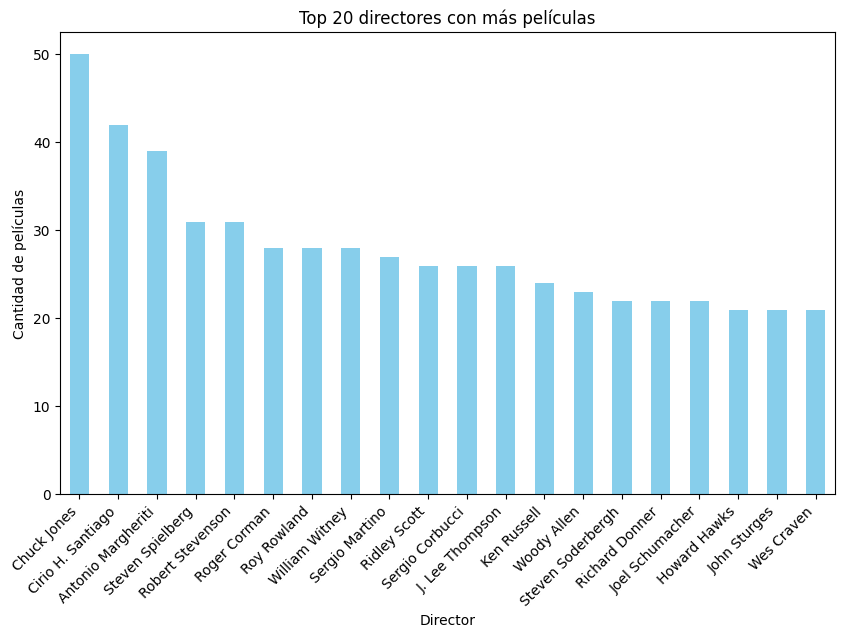

In [63]:

# Mostrar cuántos directores únicos hay
num_directores = df['Director'].nunique()
print(f"Número total de directores únicos: {num_directores}")

# Mostrar los 20 directores con más películas en el dataset
top_directores = df['Director'].value_counts().head(20)
print("Top 20 directores con más películas:")
print(top_directores)

# Gráfico de barras de los 20 directores con más películas
plt.figure(figsize=(10,6))
top_directores.plot(kind='bar', color='skyblue')
plt.title('Top 20 directores con más películas')
plt.xlabel('Director')
plt.ylabel('Cantidad de películas')
plt.xticks(rotation=45, ha='right')
plt.show()

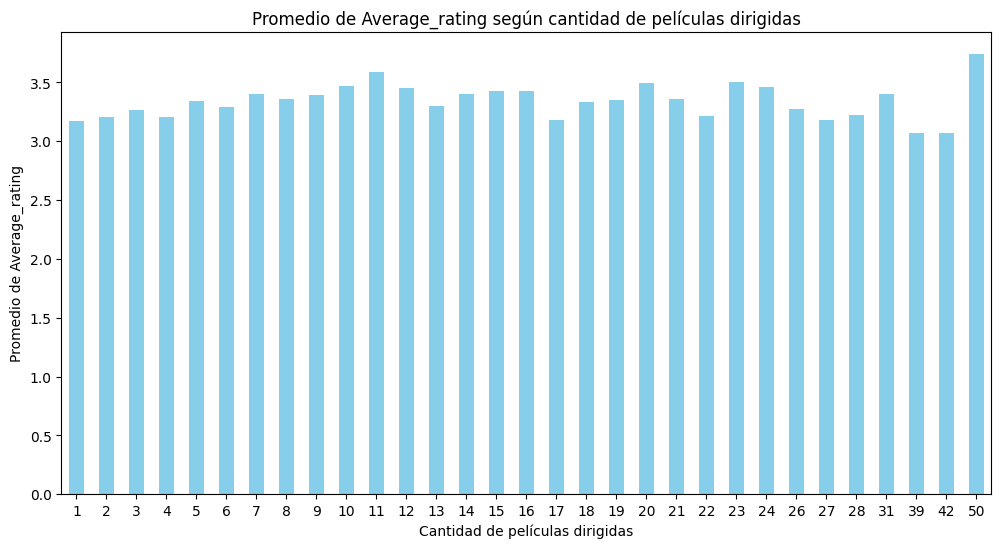

In [64]:
# Contar cuántas películas tiene cada director
peliculas_por_director = df['Director'].value_counts()

# Crear un DataFrame con director y cantidad de películas
df_directores = pd.DataFrame({
    'Director': peliculas_por_director.index,
    'Cantidad_peliculas': peliculas_por_director.values
})

# Unir con el dataset original para obtener el Average_rating por director
df_merge = pd.merge(df, df_directores, on='Director')

# Calcular promedio de Average_rating agrupado por cantidad de películas dirigidas
rating_por_cantidad = df_merge.groupby('Cantidad_peliculas')['Average_rating'].mean()

# Gráfico
plt.figure(figsize=(12,6))
rating_por_cantidad.plot(kind='bar', color='skyblue')
plt.title('Promedio de Average_rating según cantidad de películas dirigidas')
plt.xlabel('Cantidad de películas dirigidas')
plt.ylabel('Promedio de Average_rating')
plt.xticks(rotation=0)
plt.show()

Vemos que por más que los directores hagan una sóla película, el promedio del rating no es malo, por encima de 3 puntos.
Como es de esperar el director Chuck Jones que hizo 50 películas tiene un promedio por encima de 3.5. Pero Cirio H. Santiago y Antonio Margheriti tienen mucho menos, promedian 3 puntos.

# Análisis de la variable Genres

In [65]:
import ast

def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return val  # Si no puede convertir, devuelve el valor tal cual

df['Genres_original'] = df['Genres']

df['Genres'] = df['Genres'].apply(safe_literal_eval)


In [66]:
### pensar si esto hay que hacer de df o de X_train

print(df['Genres'].apply(type).value_counts())
df['Genres'] = df['Genres'].astype(str).str.replace("'", '"')  # Cambiar comillas simples por dobles
df['Genres'].head()
import json
def parse_json(val):
    try:
        return json.loads(val)
    except json.JSONDecodeError:
        return []

df['Genres'] = df['Genres'].apply(parse_json)

df['Genres'].head()

Genres
<class 'list'>    9976
<class 'str'>       24
Name: count, dtype: int64


0                         [Horror, Drama]
1    [Adventure, Science Fiction, Action]
2                                [Horror]
3                [Drama, Comedy, Romance]
4    [Animation, Action, Science Fiction]
Name: Genres, dtype: object

<Figure size 1200x600 with 0 Axes>

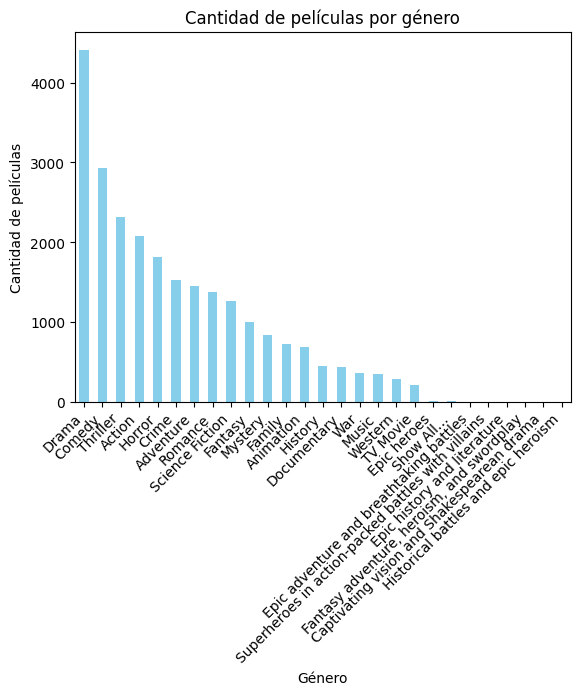

27


In [67]:

# Aplanar la lista de géneros
all_genres = [genre for sublist in df['Genres'] for genre in sublist]

# Contar frecuencia
genre_counts = Counter(all_genres)

# Convertir a DataFrame para graficar
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['Count'])
genre_counts_df = genre_counts_df.sort_values('Count', ascending=False)

# Graficar
plt.figure(figsize=(12,6))
genre_counts_df.plot(kind='bar', legend=False, color='skyblue')
plt.title('Cantidad de películas por género')
plt.xlabel('Género')
plt.ylabel('Cantidad de películas')
plt.xticks(rotation=45, ha='right')
plt.show()

print(len(genre_counts))

Confirmamos que no hay valores nulos y hay 27 géneros distintos.

Estadísticas descriptivas de Runtime:
count    10000.000000
mean       103.169352
std         38.070735
min          2.000000
25%         89.000000
50%         99.000000
75%        113.000000
max        907.000000
Name: Runtime, dtype: float64


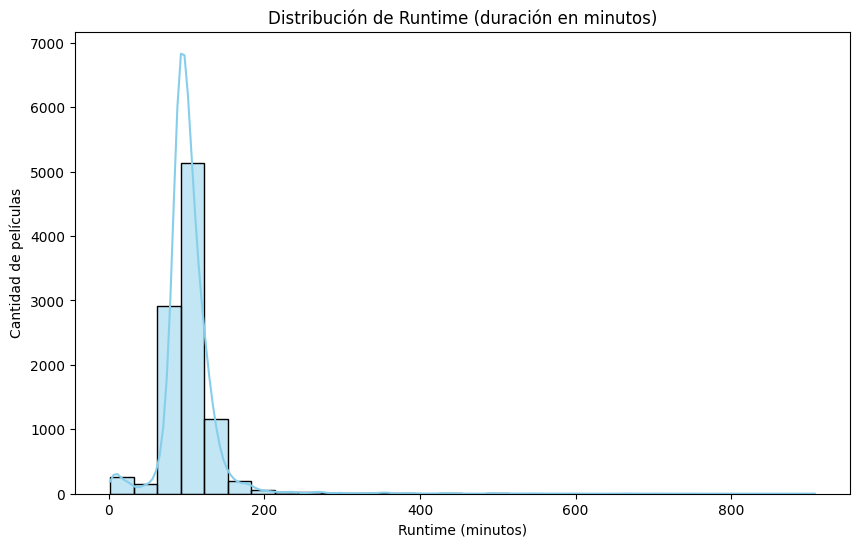

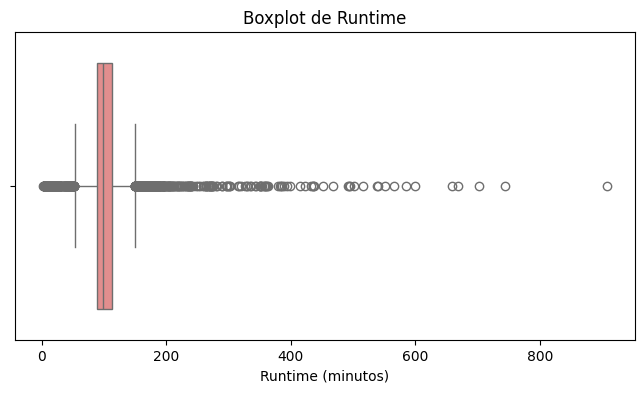

In [68]:
# Estadísticas descriptivas
print("Estadísticas descriptivas de Runtime:")
print(df['Runtime'].describe())

# Histograma de la distribución de Runtime
plt.figure(figsize=(10,6))
sns.histplot(df['Runtime'], bins=30, kde=True, color='skyblue')
plt.title('Distribución de Runtime (duración en minutos)')
plt.xlabel('Runtime (minutos)')
plt.ylabel('Cantidad de películas')
plt.show()

# Boxplot para detectar outliers
plt.figure(figsize=(8,4))
sns.boxplot(x=df['Runtime'], color='lightcoral')
plt.title('Boxplot de Runtime')
plt.xlabel('Runtime (minutos)')
plt.show()

Notamos muchos outliers
Por la duración creemos que no todas son peliculas.
### ver que hacer con esto y si afecta algo al resultado ###

In [69]:
X_train.head()

,Director,Genres,Runtime,Original_language,Studios,Watches
9254,Mai Masri,"['History', 'Documentary']",50.0,Arabic,"['Arab Film Distribution', 'Nour Productions']",1761
1561,Steven Spielberg,"['War', 'Adventure', 'History']",146.0,English,"['DreamWorks Pictures', 'Reliance Entertainmen...",218184
1670,"Mel Welles, Aureliano Luppi","['Horror', 'Science Fiction']",99.0,Italian,"['Condor International Productions', 'New Worl...",3861
6087,Arch Hall Sr.,"['Science Fiction', 'Romance', 'Horror']",92.0,English,['Fairway International Pictures'],4725
6669,Humberto Hinojosa,"['Comedy', 'Drama', 'Science Fiction']",94.0,Spanish,"['Filmadora Nacional', 'Tigre Pictures', 'Film...",2919


In [70]:
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, RobustScaler
from sklearn.ensemble import RandomForestRegressor

def join_genres(X):
    X = X.copy()
    X["Genres"] = X["Genres"].apply(lambda g: "|".join(g) if isinstance(g, list) else g)
    X["Studios"] = X["Studios"].apply(lambda g: "|".join(g) if isinstance(g, list) else g)
    return X

target_columns = ["Genres", "Studios", "Director", "Original_language"]
numeric_columns = ["Watches", "Runtime"]

# Pipelines
pipeline_target = Pipeline([
    ("join_genres", FunctionTransformer(join_genres)),
    ("target_encode", TargetEncoder(cols=target_columns))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("targets", pipeline_target, target_columns),
        ("numerics", RobustScaler(), numeric_columns)
    ]
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

# -----------------------------
# 5. Fit en train y predecir en test
# -----------------------------
# Asumiendo que ya hiciste split:
# X_train, X_test, y_train, y_test

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = pipeline.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MAE: 0.3832923886848533
RMSE: 0.24999053496614942
R2: 0.08780699361825417


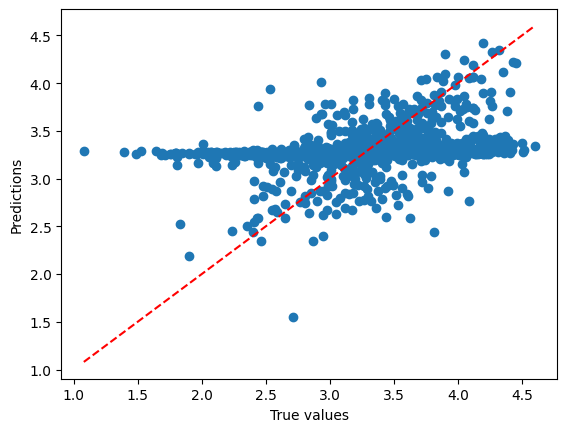

In [72]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel("True values")
plt.ylabel("Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

JONI: la predicción es muy muy mala. Ver de crear variable a partir de runtime

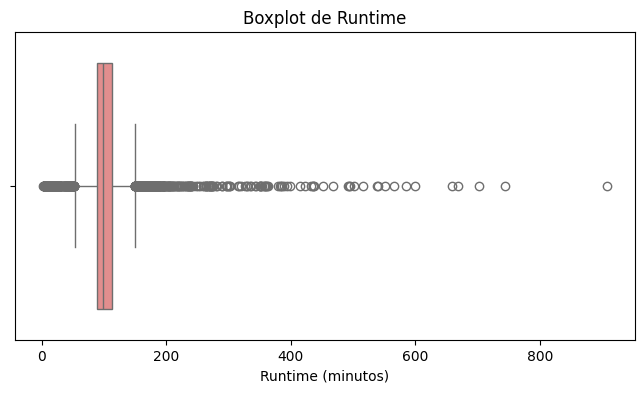

In [73]:
# Boxplot para detectar outliers
plt.figure(figsize=(8,4))
sns.boxplot(x=df['Runtime'], color='lightcoral')
plt.title('Boxplot de Runtime')
plt.xlabel('Runtime (minutos)')
plt.show()


In [74]:
peliculas_largas = df[df['Runtime'] > 200]['Film_title']
print("Películas con duración mayor a 200 minutos:")
print(peliculas_largas.to_list())

Películas con duración mayor a 200 minutos:
['Lawrence of Arabia', 'Gone with the Wind', 'The Godfather Part II', 'O.J.: Made in America', 'War and Peace', '1900', 'Ben-Hur', 'The Ten Commandments', 'Jason and the Argonauts', 'Malcolm X', 'Giant', '11.22.63', 'Lonesome Dove', 'Ultraviolet', 'Once Upon a Time in America', 'The Stand', 'Gettysburg', 'The Night Manager', 'Shoah', 'Seven Samurai', 'The Kingdom', 'Bangkok Hilton', 'Woodstock', 'War and Peace', 'Spy Smasher', "Zorro's Fighting Legion", 'Drums of Fu Manchu', 'Mysterious Doctor Satan', 'Zorro Rides Again', 'The Fighting Devil Dogs', 'Daredevils of the Red Circle', 'Jungle Girl', 'Dick Tracy Returns', 'Dick Tracy vs. Crime Inc.', "Dick Tracy's G-Men", 'SOS Coast Guard', 'The Lone Ranger', 'Jesus of Nazareth', "Boccaccio '70", 'Out 1', 'La Belle Noiseuse', 'Homeland: Iraq Year Zero', 'Gods and Generals', 'Never Sleep Again: The Elm Street Legacy', 'Planet Earth II', 'Blue Planet II', 'Brideshead Revisited', 'Cleopatra', 'Apple T

# Analsis del idioma original de los films

In [75]:
# Conteo absoluto
conteo = df['Original_language'].value_counts()

# Porcentaje relativo
porcentaje = df['Original_language'].value_counts(normalize=True) * 100

# Unir en un DataFrame
idiomas = pd.DataFrame({
    "Conteo": conteo,
    "Porcentaje (%)": porcentaje
})

# Cantidad total de idiomas distintos
print(f"Idiomas distintos: {len(idiomas)}")

# Mostrar tabla
print(idiomas)

Idiomas distintos: 57
                                  Conteo  Porcentaje (%)
Original_language                                       
English                             8074           80.74
Italian                              396            3.96
Japanese                             308            3.08
French                               291            2.91
Korean                               145            1.45
Spanish                              115            1.15
German                                96            0.96
No spoken language                    94            0.94
Chinese                               66            0.66
Danish                                60            0.60
Cantonese                             58            0.58
Russian                               43            0.43
Swedish                               32            0.32
Dutch                                 20            0.20
Polish                                20            0.20
Portugues

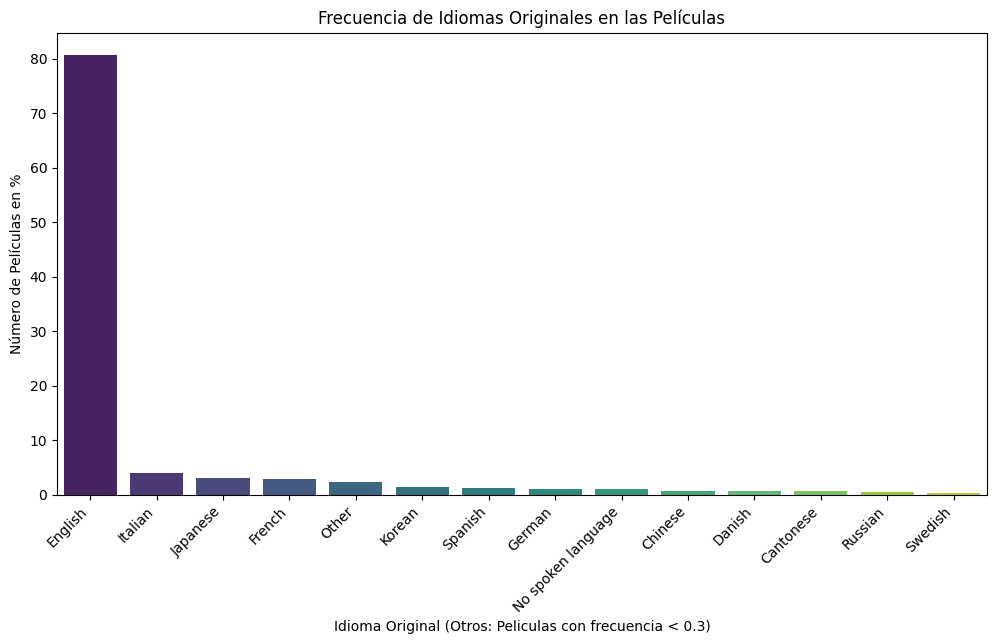

In [76]:
# Calculo del porcentaje de cada leguaje original
language_percentages = df['Original_language'].value_counts(normalize=True) * 100

# Agrupar lenguajes con 0.3% de frecuencia en la variable otros
other_languages = language_percentages[language_percentages < 0.3].index.tolist()
language_percentages_grouped = language_percentages.copy()
language_percentages_grouped['Other'] = language_percentages_grouped[other_languages].sum()
language_percentages_grouped = language_percentages_grouped.drop(other_languages)
language_percentages_grouped = language_percentages_grouped.sort_values(ascending=False)

# Gráfico de barras con la frecuencia de cada idioma
plt.figure(figsize=(12, 6))
sns.barplot(x=language_percentages_grouped.index,
            y=language_percentages_grouped.values,
            palette='viridis',
            hue=language_percentages_grouped.index,
            legend=False)
plt.title('Frecuencia de Idiomas Originales en las Películas')
plt.xlabel('Idioma Original (Otros: Peliculas con frecuencia < 0.3)')
plt.ylabel('Número de Películas en %')
plt.xticks(rotation=45, ha='right')
plt.show()

Vemos que no hay nulos y en total hay 57 idiomas diferentes, lo cual es mucho.
Luego vamos a agrupar los idiomas antes de hacer un one hot encoding o target encoding

Las clases Movie y Show tienen medias distintas y no tienen nulos. Por ahora es relevante y no hace falta imputar. Sólo convertirla a númerica.

In [77]:
print("Valores vacíos en 'Description':", (df['Description'].str.strip() == '').sum())

Valores vacíos en 'Description': 0


Estadísticas de longitud de descripción:
count    10000.000000
mean       264.950200
std        141.208441
min         25.000000
25%        154.000000
50%        233.000000
75%        351.000000
max        998.000000
Name: desc_length, dtype: float64


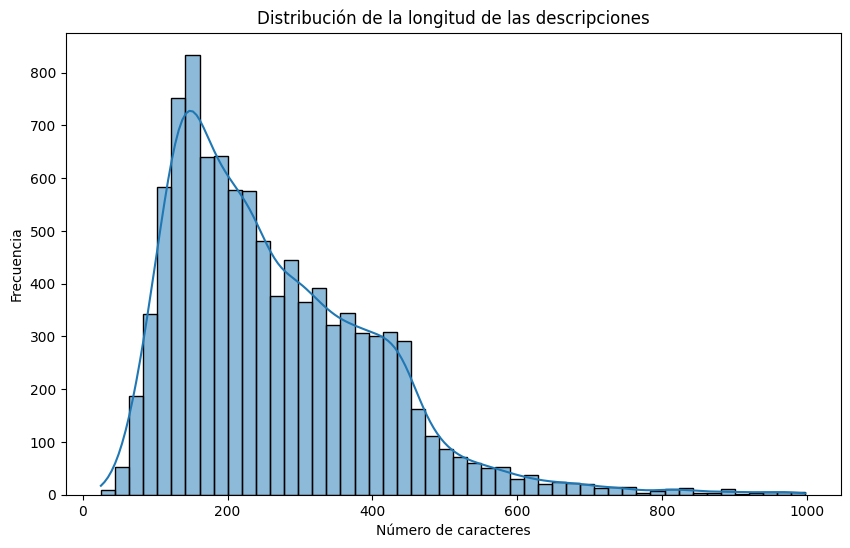

In [78]:
df['desc_length'] = df['Description'].fillna('').apply(len)
# Estadísticas básicas
print("Estadísticas de longitud de descripción:")
print(df['desc_length'].describe())

# 3. Histograma de longitudes
plt.figure(figsize=(10,6))
sns.histplot(df['desc_length'], bins=50, kde=True)
plt.title('Distribución de la longitud de las descripciones')
plt.xlabel('Número de caracteres')
plt.ylabel('Frecuencia')
plt.show()

# 4. Palabras más frecuentes (simple tokenización por espacios)
all_words = ' '.join(df['Description'].dropna()).lower().split()
word_counts = Counter(all_words)

Palabras más frecuentes (excluyendo stopwords comunes):
he: 3413
their: 2800
who: 2451
when: 2415
but: 1934
they: 1914
has: 1573
into: 1551
are: 1546
she: 1532
after: 1500
young: 1243
new: 1220
one: 1120
him: 1096
up: 1086
out: 1009
two: 980
be: 936
life: 922


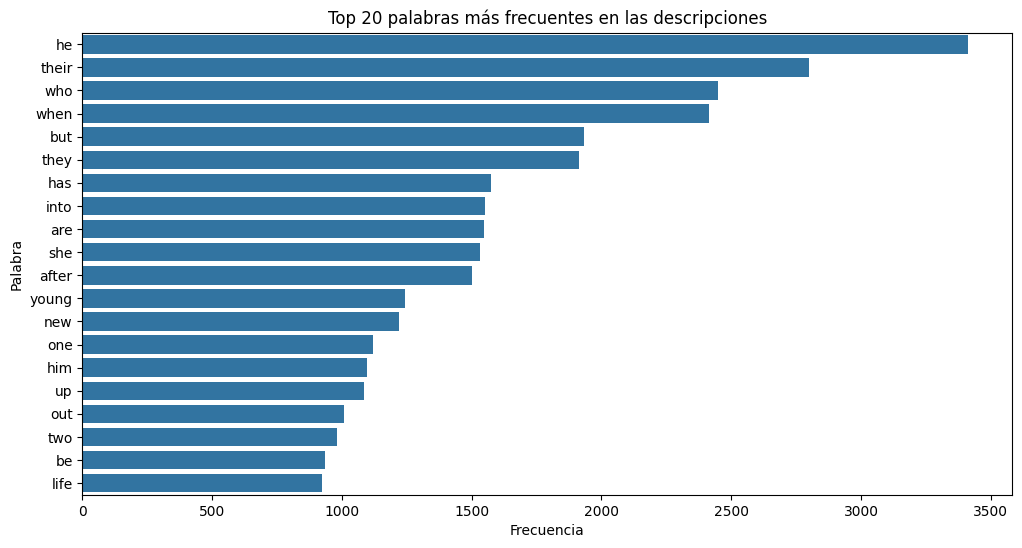

In [79]:
# Mostrar las 20 palabras más comunes excluyendo stopwords básicas
stopwords = set(['the', 'a', 'and', 'of', 'to', 'in', 'is', 'with', 'on', 'for', 'as', 'an', 'at', 'by', 'from', 'it', 'this', 'that', 'his', 'her'])
filtered_words = {word: count for word, count in word_counts.items() if word not in stopwords}

most_common = Counter(filtered_words).most_common(20)
print("Palabras más frecuentes (excluyendo stopwords comunes):")
for word, count in most_common:
    print(f"{word}: {count}")

# Opcional: gráfico de barras para las palabras más frecuentes
words, counts = zip(*most_common)
plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Top 20 palabras más frecuentes en las descripciones')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.show()

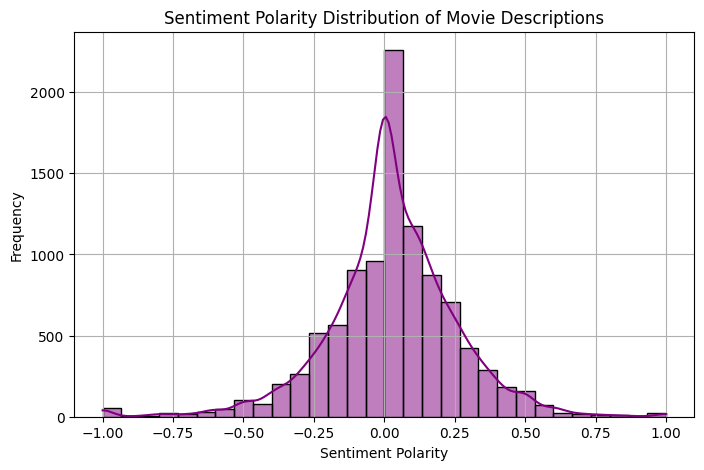

In [80]:
from textblob import TextBlob

df['Sentiment'] = df['Description'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(8,5))
sns.histplot(df['Sentiment'], bins=30, kde=True, color='purple')
plt.title("Sentiment Polarity Distribution of Movie Descriptions")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### no sabemos que hacer con esto, tal vez en al pasarla a numerica podamos hacer algo mejor

## Variable Studios

/var/folders/_f/7gqqb6190c9b0h_7dkhypsj80000gn/T/ipykernel_5422/3001274545.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_studios_watch.values, y=top_studios_watch.index, palette='YlGnBu')


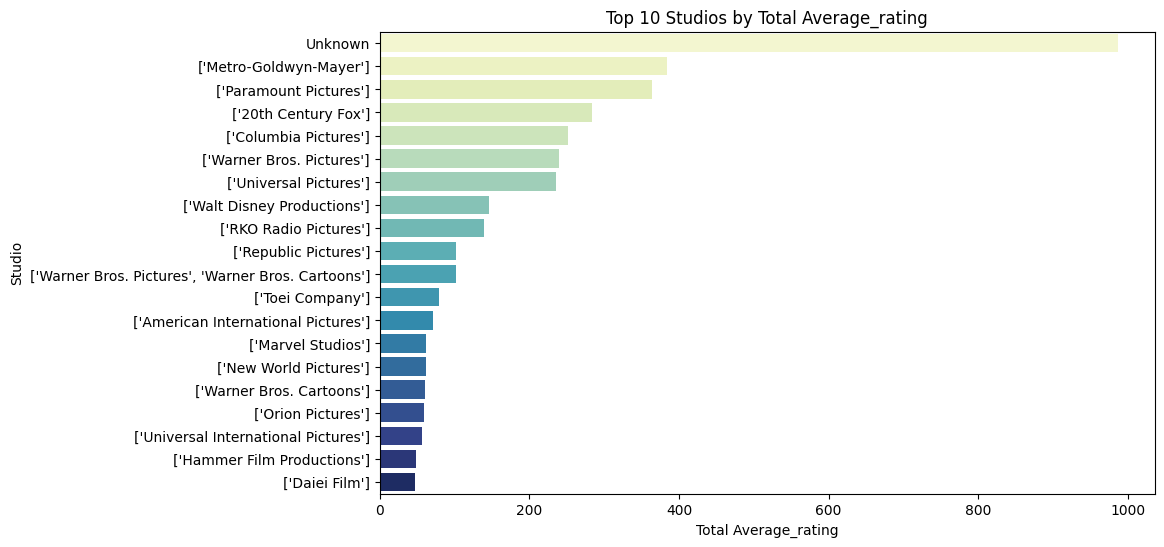

In [81]:
studio_list = df['Studios'].explode()
df_exploded = df.explode('Studios')  # so we can use it for aggregation

studio_watch = df_exploded.groupby('Studios')['Average_rating'].sum()
top_studios_watch = studio_watch.sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_studios_watch.values, y=top_studios_watch.index, palette='YlGnBu')
plt.title("Top 10 Studios by Total Average_rating")
plt.xlabel("Total Average_rating")
plt.ylabel("Studio")
plt.show()

/var/folders/_f/7gqqb6190c9b0h_7dkhypsj80000gn/T/ipykernel_5422/1900431273.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=studios_df, x='Count', y='Studio', palette='viridis')


Top 20 estudios más frecuentes:
Warner Bros. Pictures: 502
Paramount Pictures: 423
Columbia Pictures: 411
Universal Pictures: 410
20th Century Fox: 367
Metro-Goldwyn-Mayer: 317
Unknown: 307
United Artists: 165
New Line Cinema: 146
Walt Disney Pictures: 116
Lionsgate: 93
Film4 Productions: 91
Touchstone Pictures: 83
Relativity Media: 82
American International Pictures: 82
Working Title Films: 78
DreamWorks Pictures: 77
TriStar Pictures: 73
Orion Pictures: 71
Village Roadshow Pictures: 70


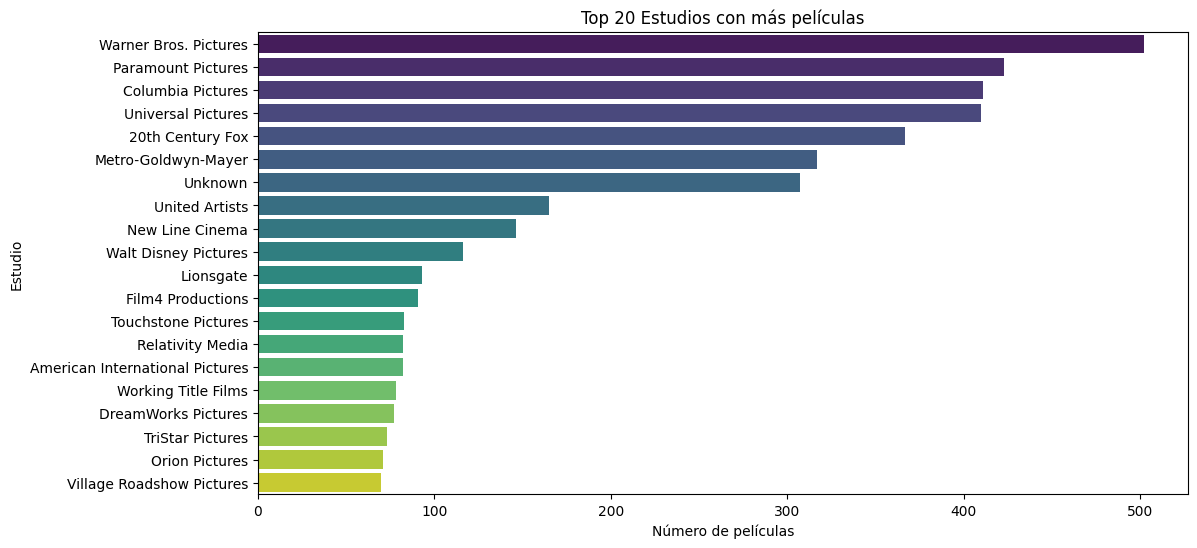

Cantidad de estudios diferentes: 10155
{'Canterbury Productions', 'Enigma Ace Films', 'Village Roadshow Entertainment', 'DigitalKraft', 'CreatorVC', 'USA Network', 'Peter Thomas Productions', 'Unit Four', 'Office Kitano', 'Tribeca Productions', 'Perfect Storm Entertainment', 'ITM Productions', 'Worrying Drake Productions', 'Uncorked Productions', 'ECTA Filmproduktion', 'Titan Global Entertainment', 'Stéphan Films', 'Thirteen Productions', 'Arco Film', 'Josephson & Nykvist HB', 'Worldwide Media', 'Friland', 'Many Rivers Productions', 'Rubber Films', 'Atacama Productions', "L'immagine S.r.l.", 'Fonds Sud Cinéma', 'Mace Neufeld Productions', 'Mercury Productions', 'Greencard Pictures', 'Kingston Film Productions Ltd.', 'Jon Shestack Productions', 'DDM Film Corporation', 'Millar Gough Ink', 'No. 3 Production', 'CAA', 'KNM', 'KDDI', 'Electric Somewhere', 'Zora Investments Associates', 'Edge City Productions', 'Mainline Releasing', 'Marco Weber/Lisa Tornell Productions', 'Blue Wolf', 'Atlant

In [82]:
import ast
from collections import Counter
import pandas as pd

def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return val  # Devuelve el valor original si no es evaluable

# Suponiendo df ya cargado
df['Studios_original'] = df['Studios']
df['Studios'] = df['Studios'].apply(safe_literal_eval)

# Ahora solo aplanar cuando sea lista, sino ignorar o convertir en lista de un solo elemento
all_studios = []
for item in df['Studios']:
    if isinstance(item, list):
        all_studios.extend(item)
    elif isinstance(item, str):
        # Por si algunos son strings simples, añadir como único estudio
        all_studios.append(item)
    else:
        # Si es otro tipo, puedes ignorar o manejar según convenga
        pass

# Contar frecuencia
studio_counts = Counter(all_studios)


# Mostrar top 20
most_common_studios = studio_counts.most_common(20)
print("Top 20 estudios más frecuentes:")
for studio, count in most_common_studios:
    print(f"{studio}: {count}")


# Convertir a DataFrame para graficar
studios_df = pd.DataFrame(most_common_studios, columns=['Studio', 'Count'])

# Gráfico de barras
plt.figure(figsize=(12,6))
sns.barplot(data=studios_df, x='Count', y='Studio', palette='viridis')
plt.title('Top 20 Estudios con más películas')
plt.xlabel('Número de películas')
plt.ylabel('Estudio')
plt.show()

num_studios_unicos = len(set(all_studios))
print(f"Cantidad de estudios diferentes: {num_studios_unicos}")
print(set(all_studios))

Vemos que hay más de 300 peliculas que tiene el studio Unknown

# Analisis de la variable Watches

Valores nulos en Watches: 0

Resumen estadístico de Watches:
count    1.000000e+04
mean     1.703148e+05
std      4.585329e+05
min      2.000000e+00
25%      2.979750e+03
50%      1.842500e+04
75%      1.083580e+05
max      5.195503e+06
Name: Watches, dtype: float64


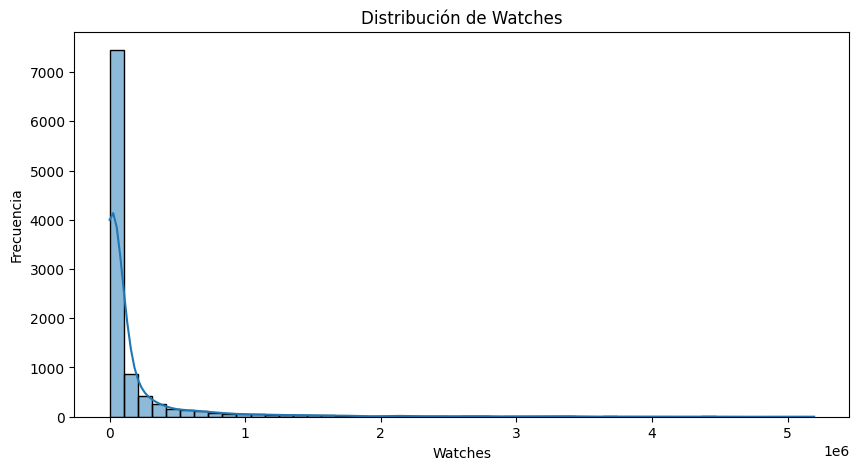

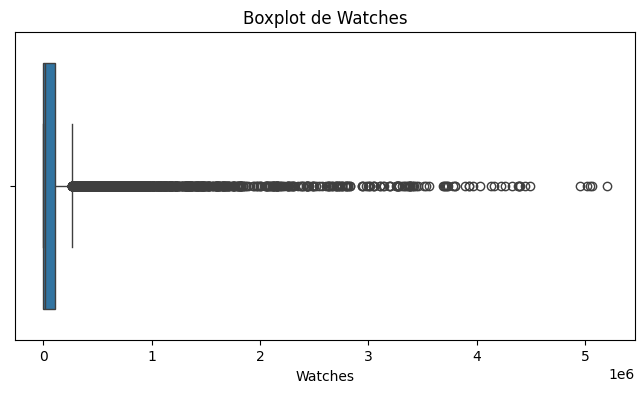


Cantidad de outliers: 1427
Ejemplos de outliers:
                    Film_title  Watches
1           Mad Max: Fury Road  2488721
2                     Suspiria   618171
3          Lost in Translation  1596190
4                        Akira   873068
6  Big Trouble in Little China   283873


In [83]:
print("Valores nulos en Watches:", df['Watches'].isnull().sum())
print("\nResumen estadístico de Watches:")
print(df['Watches'].describe())

# --- 2. Histograma ---
plt.figure(figsize=(10,5))
sns.histplot(df['Watches'], bins=50, kde=True)
plt.title('Distribución de Watches')
plt.xlabel('Watches')
plt.ylabel('Frecuencia')
plt.show()

# --- 3. Boxplot para detectar outliers ---
plt.figure(figsize=(8,4))
sns.boxplot(x=df['Watches'])
plt.title('Boxplot de Watches')
plt.show()

# --- 4. Detectar valores atípicos ---
Q1 = df['Watches'].quantile(0.25)
Q3 = df['Watches'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['Watches'] < (Q1 - 1.5 * IQR)) | (df['Watches'] > (Q3 + 1.5 * IQR))]

print(f"\nCantidad de outliers: {len(outliers)}")
print("Ejemplos de outliers:")
print(outliers[['Film_title', 'Watches']].head())

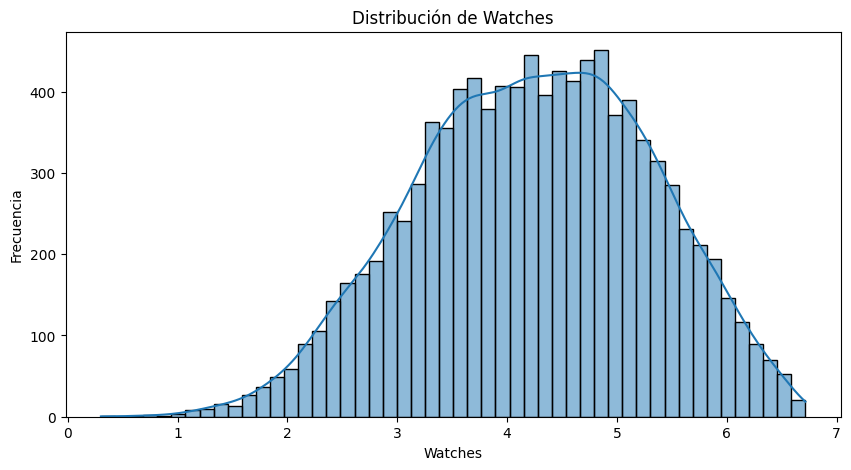

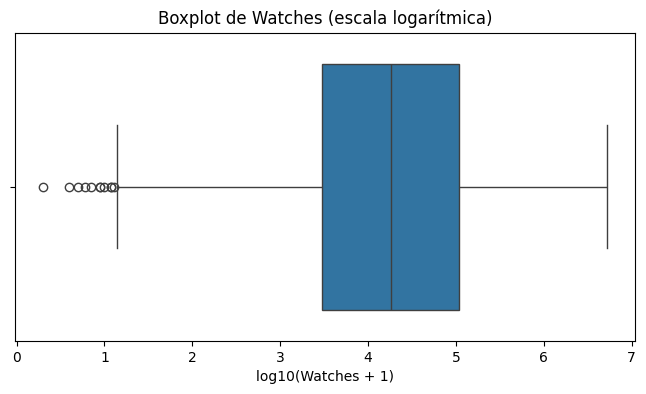

In [84]:
import numpy as np

plt.figure(figsize=(10,5))
sns.histplot(x=np.log10(df['Watches']), bins=50, kde=True)
plt.title('Distribución de Watches')
plt.xlabel('Watches')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x=np.log10(df['Watches']))  # log1p para evitar problemas con ceros
plt.title('Boxplot de Watches (escala logarítmica)')
plt.xlabel('log10(Watches + 1)')
plt.show()

Se cambió la escala a Logarítmica para que los datos esten dentro de los percentiles

# Analisis List_appearances


===== List_appearances =====
count     10000.000000
mean      26868.798600
std       56751.328696
min          33.000000
25%        1674.000000
50%        6503.000000
75%       23908.250000
max      803670.000000
Name: List_appearances, dtype: float64
Valores nulos: 0


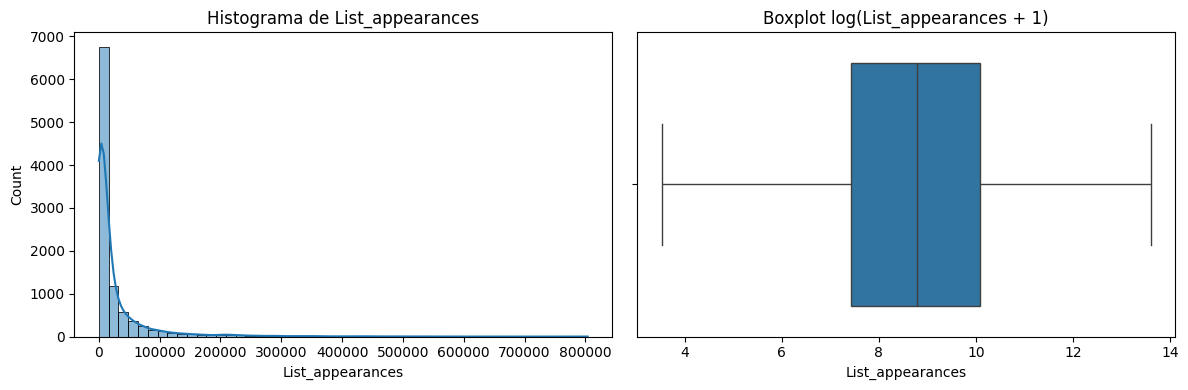

In [85]:
col = "List_appearances"

print(f"\n===== {col} =====")
print(df[col].describe())
print(f"Valores nulos: {df[col].isnull().sum()}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histograma normal
sns.histplot(df[col], bins=50, ax=axes[0], kde=True)
axes[0].set_title(f'Histograma de {col}')

# Boxplot en escala logarítmica
sns.boxplot(x=np.log1p(df[col]), ax=axes[1])
axes[1].set_title(f'Boxplot log({col} + 1)')

plt.tight_layout()
plt.show()

Tiene una distribución asimétrica positiva (Tweedie), sin outliers

# Analisis de Likes


===== Likes =====
count    1.000000e+04
mean     4.373479e+04
std      1.515314e+05
min      0.000000e+00
25%      4.570000e+02
50%      3.394000e+03
75%      2.011225e+04
max      2.730813e+06
Name: Likes, dtype: float64
Valores nulos: 0


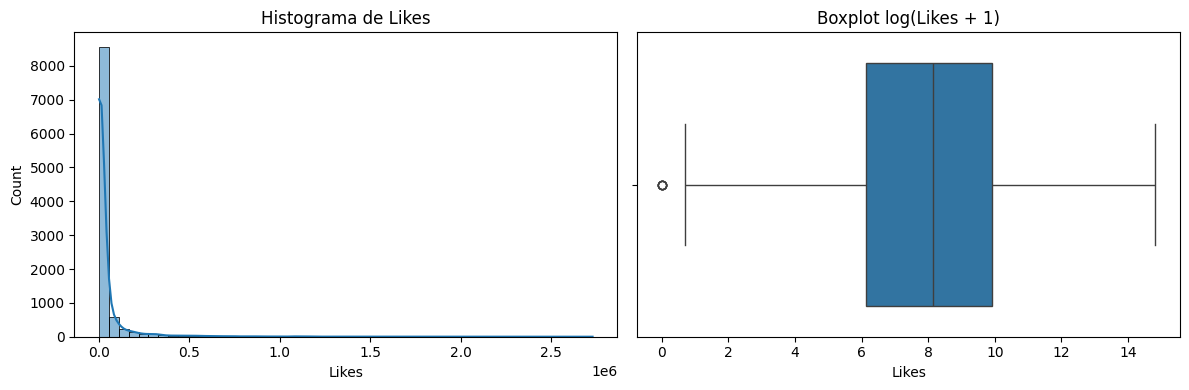

In [86]:
col = "Likes"

print(f"\n===== {col} =====")
print(df[col].describe())
print(f"Valores nulos: {df[col].isnull().sum()}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histograma normal
sns.histplot(df[col], bins=50, ax=axes[0], kde=True)
axes[0].set_title(f'Histograma de {col}')

# Boxplot en escala logarítmica
sns.boxplot(x=np.log1p(df[col]), ax=axes[1])
axes[1].set_title(f'Boxplot log({col} + 1)')

plt.tight_layout()
plt.show()

Creo que los outliers que están en cero tenemos que reemplazarlo por la mediana

# Analisis de la variable Fans


===== Fans =====
count     10000.000000
mean       1652.549700
std        9368.258118
min           0.000000
25%           2.000000
50%          24.000000
75%         283.000000
max      326000.000000
Name: Fans, dtype: float64
Valores nulos: 0


/Users/santiagocasado/Documents/AI/02 Bimestre/05 - Aprendizaje de Maquina I/Trabajo Practica Final/env311/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/santiagocasado/Documents/AI/02 Bimestre/05 - Aprendizaje de Maquina I/Trabajo Practica Final/env311/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


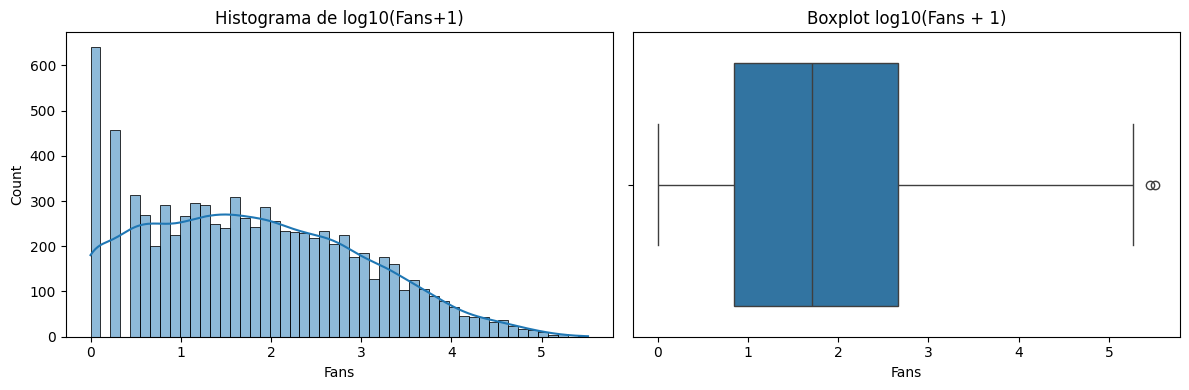

In [87]:
col = "Fans"

print(f"\n===== {col} =====")
print(df[col].describe())
print(f"Valores nulos: {df[col].isnull().sum()}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histograma normal
sns.histplot(x=np.log10(df[col]), bins=50, ax=axes[0], kde=True)
axes[0].set_title(f'Histograma de log10({col}+1)')

# Boxplot en escala logarítmica
sns.boxplot(x=np.log10(df[col]), ax=axes[1])
axes[1].set_title(f'Boxplot log10({col} + 1)')

plt.tight_layout()
plt.show()

## tenemos que consultar que hacer con Studios porque se repiten como por ejemplo Warnes Bross entertainment y Warnes Bross sarasa

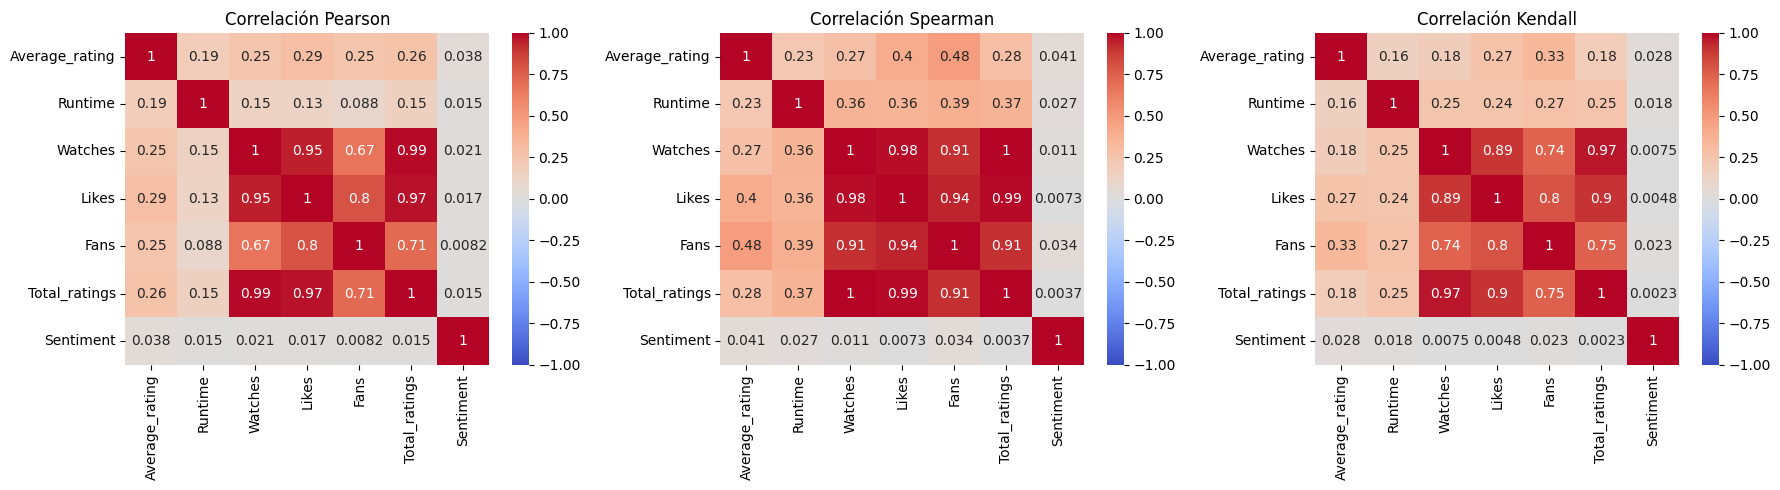

In [88]:
# Seleccionar columnas numéricas relevantes para correlación
numerical_cols = ['Average_rating', 'Runtime', 'Watches', 'Likes', 'Fans', 'Total_ratings', 'Sentiment']

df_num = df[numerical_cols]

# 1. Matriz de correlación Pearson
corr_pearson = df_num.corr(method='pearson')

# 2. Matriz de correlación Spearman
corr_spearman = df_num.corr(method='spearman')


# 3. Matriz de correlación Kendall
corr_kendall = df_num.corr(method='kendall')

# Visualización con heatmap para cada matriz
plt.figure(figsize=(18, 5))

plt.subplot(1,3,1)
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación Pearson')

plt.subplot(1,3,2)
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación Spearman')

plt.subplot(1,3,3)
sns.heatmap(corr_kendall, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación Kendall')

plt.tight_layout()
plt.show()

## EDA simple

Se hace un EDA rapido solo para justificar el procesamiento del dataset.

### Caracteristicas Generales

### Dimension

In [170]:
df_movies = df.copy()
print(df_movies.shape)

(10000, 23)


#### Tipo de datos

In [171]:
df_movies.dtypes

Film_title            object
Director              object
Average_rating       float64
Genres                object
Runtime              float64
Original_language     object
Description           object
Studios               object
Watches              float64
List_appearances     float64
Likes                float64
Fans                 float64
Lowest★              float64
Medium★★★            float64
Highest★★★★★         float64
Total_ratings        float64
Genres_original       object
desc_length          float64
Sentiment            float64
Studios_original      object
Cluster                int32
Cluster_GMM          float64
Cluster_Spectral       int32
dtype: object

### Título (`Film_title`)

In [155]:
df_movies['Film_title'].value_counts()

Film_title
Hercules                        6
Beauty and the Beast            5
A Star Is Born                  4
The Babysitter                  4
The Black Hole                  4
                               ..
Ultimate Avengers: The Movie    1
Step Up                         1
Awaydays                        1
She                             1
Roujin Z                        1
Name: count, Length: 9665, dtype: int64

La cantidad de titulos es muy similar a la cantidad de peliculas del dataset.

### Lenguaje

**!!! Este estudio sew hizo antes**

In [156]:
conteo_lenguajes = df_movies['Original_language'].value_counts()

# Calcular porcentajes
porcentajes_lenguajes = (conteo_lenguajes / conteo_lenguajes.sum()) * 100

print("Distribución de lenguajes originales:")
print(porcentajes_lenguajes.round(2))


Distribución de lenguajes originales:
Original_language
English                             80.74
Italian                              3.96
Japanese                             3.08
French                               2.91
Korean                               1.45
Spanish                              1.15
German                               0.96
No spoken language                   0.94
Chinese                              0.66
Danish                               0.60
Cantonese                            0.58
Russian                              0.43
Swedish                              0.32
Dutch                                0.20
Polish                               0.20
Portuguese                           0.19
Romanian                             0.18
Persian (Farsi)                      0.15
Arabic                               0.14
Norwegian                            0.14
Czech                                0.12
Hindi                                0.09
Greek (modern)      

### Generos

In [164]:
import ast

def parse_genres(val):
    if pd.isna(val):
        return []
    if isinstance(val, list):
        return val
    try:
        return ast.literal_eval(val)
    except:
        return [val]
    
# Se convierte a tipo lista la variable 'Genres'
df_movies['Genres'] = df_movies['Genres'].apply(parse_genres)

In [165]:
print(df_movies['Genres'].head())

0                        [Horror|Drama]
1    [Adventure|Science Fiction|Action]
2                              [Horror]
3                [Drama|Comedy|Romance]
4    [Animation|Action|Science Fiction]
Name: Genres, dtype: object


In [166]:
print(type(df_movies['Genres'][0]))

<class 'list'>


Se observa que cada pelicula puede tener mas de un género y se declaran a partir de un string como si fuera una lista.

### Conversión de tipos

In [158]:
# Categoricas

# Convertir listas a string antes de categorizar
df_movies['Genres'] = df_movies['Genres'].apply(lambda x: '|'.join(x) if isinstance(x, list) else str(x))
df_movies['Studios'] = df_movies['Studios'].apply(lambda x: '|'.join(x) if isinstance(x, list) else str(x))

categoricas = ['Film_title', 'Director', 'Genres', 'Original_language', 'Description', 'Studios']
df_movies[categoricas] = df_movies[categoricas].astype('category')

df_movies.dtypes
df_movies.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Film_title         10000 non-null  category
 1   Director           10000 non-null  category
 2   Average_rating     10000 non-null  float64 
 3   Genres             10000 non-null  category
 4   Runtime            10000 non-null  float64 
 5   Original_language  10000 non-null  category
 6   Description        10000 non-null  category
 7   Studios            10000 non-null  category
 8   Watches            10000 non-null  float64 
 9   List_appearances   10000 non-null  float64 
 10  Likes              10000 non-null  float64 
 11  Fans               10000 non-null  float64 
 12  Lowest★            10000 non-null  float64 
 13  Medium★★★          10000 non-null  float64 
 14  Highest★★★★★       10000 non-null  float64 
 15  Total_ratings      10000 non-null  float64 
 16  Genre

## Procesamiento

In [152]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer


### Variables categoricas

#### Titulos

Debido a que `Film_title` corresponde a el nombre de cada película, tomará valores unicos (en la mayoría del dataset) y se lo puede considerar como un ID por lo que no es un feature apto para realizar un modelo de clustering.

#### Director

Features de alta cardinalidad, se utiliza Frequency Encoding. No se realiza One Hot Encoding para evitar alta dimensionalidad y esparsidad excesiva, degradando la calidad de un modelo de clustering.

#### Géneros

In [159]:
import ast
import pandas as pd

def parse_genres(val):
    if val is None or (isinstance(val, float) and pd.isna(val)):
        return []
    if isinstance(val, list):
        return val
    if isinstance(val, str):
        try:
            result = ast.literal_eval(val)
            if isinstance(result, list):
                return result
            else:
                return [result]
        except Exception:
            return [val]
    return [val]

# Se convierte a tipo lista la variable 'Genres'
df_movies['Genres'] = df_movies['Genres'].apply(parse_genres)


TypeError: unhashable type: 'list'

In [ ]:
df_movies['Genres'].head()

0                         [Horror, Drama]
1    [Adventure, Science Fiction, Action]
2                                [Horror]
3                [Drama, Comedy, Romance]
4    [Animation, Action, Science Fiction]
Name: Genres, dtype: object

In [ ]:
print(type(df_movies['Genres'][0]))

<class 'list'>


Se utilizan los 19 primeros generos mas frecuentes:

In [ ]:
from collections import Counter

all_genres = [g for sublist in df_movies['Genres'] for g in sublist]
counter = Counter(all_genres)

top_19 = [g for g, _ in counter.most_common(19)]
print("Top 19 géneros:", top_19)

Top 19 géneros: ['Drama', 'Comedy', 'Thriller', 'Action', 'Horror', 'Crime', 'Adventure', 'Romance', 'Science Fiction', 'Fantasy', 'Mystery', 'Family', 'Animation', 'History', 'Documentary', 'War', 'Music', 'Western', 'TV Movie']


El resto se pasa a una nueva categoria 'Others':

In [ ]:
def reemplazar_Others(genres):
    return [g if g in top_19 else "Others" for g in genres]



df_movies['Genres'] = df_movies['Genres'].apply(reemplazar_Others)
df_movies['Genres'] = df_movies['Genres'].apply(lambda x: '|'.join(x))

df_movies['Genres'].info()
df_movies.info()


<class 'pandas.core.series.Series'>
RangeIndex: 10000 entries, 0 to 9999
Series name: Genres
Non-Null Count  Dtype 
--------------  ----- 
10000 non-null  object
dtypes: object(1)
memory usage: 78.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         10000 non-null  int64  
 1   Film_title         10000 non-null  object 
 2   Director           10000 non-null  object 
 3   Average_rating     10000 non-null  float64
 4   Genres             10000 non-null  object 
 5   Runtime            10000 non-null  float64
 6   Original_language  10000 non-null  object 
 7   Description        10000 non-null  object 
 8   Studios            10000 non-null  object 
 9   Watches            10000 non-null  int64  
 10  List_appearances   10000 non-null  int64  
 11  Likes              10000 non-null  int64  
 12  Fans        

Debido a que `Genre` tiene cardinalidad baja, se utilzará `Multi Label Binarizer` para codificar los datos. De esta manera, se crea una columna booleana para cada género donde tomará el valor 1 si este pertenece a la película. Cabe mencionar que las columnas no son mutuamente excluyentes, por lo que se respeta que pueda cada una tener mas de un genero.

#### Lenguajes

Se eligen los primeros 9 lenguajes mas frecuentes. El resto se pasa a la categoria 'others'.

In [ ]:
# Se muestra el Top 9 de lenguajes

top_9_lenguajes = df_movies['Original_language'].value_counts().head(9).index.tolist()
print(top_9_lenguajes)

['English', 'Italian', 'Japanese', 'French', 'Korean', 'Spanish', 'German', 'No spoken language', 'Chinese']


In [ ]:
# Nueva columna para agrupar los lenguajes
df_movies['Language_group'] = df_movies['Original_language'].apply(
    lambda x: x if x in top_9_lenguajes else 'Others'
)

df_movies['Language_group'] = df_movies['Language_group'].astype('category')

# Se verifica que los que estan con la categoría "Others" no pertenecen a los 9 lenguajes más comunes
df_movies[df_movies['Language_group'] == 'Others'][['Original_language', 'Language_group']].head()

,Original_language,Language_group
66,Cantonese,Others
73,Indonesian,Others
114,Russian,Others
115,Russian,Others
166,Swedish,Others


Como `Language_group` tiene cardinalidad 10, se utilizará One Hot Encoding para codificar.

### Variables Numéricas

#### Rating `Average_rating`

#### Duración `Runtime`

Para el tiempo de duración se hará lo siguiente:
- Se discretiza en 4 grupos ordinales.
    - 0 - 80: corta
    - 81 - 120: mediana
    - 121 - 180: alta
    - 181 y más: muy alta (o serie)
- Se normalizan esos 4 valores en un rango de 0 a 1.

#### Vistas `Watches`

#### Apariciones en lista `List_appearances`

#### `Likes`

#### `Fans`

#### Puntuaciones (`Lowest`, `Medium`, `Highest`)

### Transformación de datos

In [98]:
# Se agrupan las columnas por tipo de datos o cardinalidad
numericas = []
binarias = []
temporales = []
ordinales = []
baja_cardinalidad = ['Language_group']
alta_cardinalidad = ['Director', 'Studios']

#### Transformar `Genres`

In [99]:
mlb = MultiLabelBinarizer()

mlb_encode = mlb.fit_transform(df_movies['Genres'])

mlb = MultiLabelBinarizer()
df_genres = pd.DataFrame(
    mlb.fit_transform(df_movies['Genres'].str.split('|')),
    columns=mlb.classes_,
    index=df_movies.index
)

df_genres.head()

,,Action,Adventure,Animation,Captivating vision and Shakespearean drama,Comedy,Crime,Documentary,Drama,Epic adventure and breathtaking battles,...,Music,Mystery,Romance,Science Fiction,Show All…,Superheroes in action-packed battles with villains,TV Movie,Thriller,War,Western
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [100]:
binarias = df_genres.columns.tolist()
# Se concatena al dataframe original

df_movies_preprocesado = pd.concat([df_movies.drop(columns=['Genres']), df_genres], axis=1)
df_movies_preprocesado.head()

,Unnamed: 0,Film_title,Director,Average_rating,Runtime,Original_language,Description,Studios,Watches,List_appearances,...,Music,Mystery,Romance,Science Fiction,Show All…,Superheroes in action-packed battles with villains,TV Movie,Thriller,War,Western
0,0,The Fan,Eckhart Schmidt,3.57,92.0,German,The hero-worship that Simone has for a pop sin...,Barbara Moorse Workshop,12841,11032,...,0,0,0,0,0,0,0,0,0,0
1,1,Mad Max: Fury Road,George Miller,4.18,121.0,English,An apocalyptic story set in the furthest reach...,Warner Bros. Pictures|Village Roadshow Picture...,2488721,331681,...,0,0,0,1,0,0,0,0,0,0
2,2,Suspiria,Dario Argento,3.93,99.0,English,An American newcomer to a prestigious German b...,Seda Spettacoli,618171,220094,...,0,0,0,0,0,0,0,0,0,0
3,3,Lost in Translation,Sofia Coppola,3.79,102.0,English,"Two lost souls visiting Tokyo -- the young, ne...",American Zoetrope|Elemental Films,1596190,254180,...,0,0,1,0,0,0,0,0,0,0
4,4,Akira,Katsuhiro Otomo,4.28,124.0,Japanese,A secret military project endangers Neo-Tokyo ...,MBS|Sumitomo Corporation|TOHO|Studio Fuga|Stud...,873068,175586,...,0,0,0,1,0,0,0,0,0,0


#### Transformar Baja Cardinalidad

In [101]:
transformar_baja_cardinalidad = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

#### Transformar Alta Cardinalidad

In [103]:
# Frecuency encoding
def freq_encode_list_col_ft(X):
    # Convertir a Series para facilidad
    if isinstance(X, np.ndarray):
        s = pd.Series(X[:,0])
    else:
        s = pd.Series(X.iloc[:,0])

    # Parsear strings tipo "['a','b']" a listas
    s = s.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else ([x] if pd.notna(x) else []))

    # Contar frecuencia global
    all_items = [i for sublist in s for i in sublist]
    counts = Counter(all_items)

    # Codificar cada fila como promedio de frecuencias
    freq = s.apply(lambda lst: sum(counts.get(x,0) for x in lst)/len(lst) if lst else 0)

    return freq.to_numpy().reshape(-1,1)

from sklearn.base import BaseEstimator, TransformerMixin


# Clase para matener el nombre de la columna
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, func):
        self.func = func

    def fit(self, X, y=None):
        self.encoders_ = {}
        for col in X.columns:
            freqs = X[col].value_counts(normalize=True)
            self.encoders_[col] = freqs
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in X.columns:
            X_transformed[col] = X[col].map(self.encoders_[col]).fillna(0)
        return X_transformed

    def get_feature_names_out(self, input_features=None):
        return input_features

transformar_nominales = Pipeline([
    ("freq", FrequencyEncoder(freq_encode_list_col_ft)),
    ("scaler", MinMaxScaler())
])

#### Transformar `Runtime`

In [130]:
# Codificar la duracion
def codificar_duracion(X):
    # Convertir a Series para facilidad
    if isinstance(X, np.ndarray):
        s = pd.Series(X[:,0])
    else:
        s = pd.Series(X.iloc[:,0])

    bins = [0, 80, 120, 180, float("inf")]
    labels = [0, 1, 2, 3]

    duracion_cat = pd.cut(
        X["Runtime"], bins=bins, labels=labels, right=True, ordered=True
    ).astype(int)

    return duracion_cat.to_numpy().reshape(-1,1)

# Clase para matener el nombre de la columna
class RuntimeEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, func):
        self.func = func

    def fit(self, X, y=None):
        self.encoders_ = {}
        for col in X.columns:
            freqs = X[col].value_counts(normalize=True)
            self.encoders_[col] = freqs
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in X.columns:
            X_transformed[col] = X[col].map(self.encoders_[col]).fillna(0)
        return X_transformed

    def get_feature_names_out(self, input_features=None):
        return input_features

transformar_runtime = Pipeline([
    ("runtime", RuntimeEncoder(codificar_duracion)),
    ("scaler", MinMaxScaler())
])

In [108]:
df_movies.dtypes

Unnamed: 0              int64
Film_title           category
Director             category
Average_rating        float64
Genres               category
Runtime               float64
Original_language    category
Description          category
Studios              category
Watches                 int64
List_appearances        int64
Likes                   int64
Fans                    int64
Lowest★                 int64
Medium★★★               int64
Highest★★★★★            int64
Total_ratings           int64
Genres_original        object
desc_length             int64
Sentiment             float64
Studios_original       object
dtype: object

In [131]:
import re
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numerical_features = [col for col in df_movies.select_dtypes(include=['int64', 'float64']).columns if col in df_movies.columns]
numerical_features.remove('Runtime')
print("Columnas numéricas:", numerical_features)

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # reemplaza NaN con la mediana
    ('scaler', MinMaxScaler())])                   # escalado de las variables


runtime = ['Runtime']

baja_cardinalidad = [col for col in baja_cardinalidad if col in df_movies_preprocesado.columns]
alta_cardinalidad = [col for col in alta_cardinalidad if col in df_movies_preprocesado.columns]

preprocesamiento = ColumnTransformer(
    transformers=[
        ('numericas', numeric_transformer, numerical_features),
        #('binarios', 'passthrough', binarios),
        #('ordinales', transformar_ordinales, ordinales),
        ('runtime', transformar_runtime, runtime),
        ('multi_label', 'passthrough', binarias),
        ('ohe', transformar_baja_cardinalidad, baja_cardinalidad),
        ('freq', transformar_nominales, alta_cardinalidad),
    ],
    remainder='drop'
)

Columnas numéricas: ['Average_rating', 'Watches', 'List_appearances', 'Likes', 'Fans', 'Lowest★', 'Medium★★★', 'Highest★★★★★', 'Total_ratings', 'desc_length', 'Sentiment']


In [132]:
pipeline = Pipeline(
    steps=[('preprocesamiento', preprocesamiento)]
    )

# Se procesan los datos
df_movies_procesado = pipeline.fit_transform(df_movies_preprocesado)

pipeline


,steps,"[('preprocesamiento', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numericas', ...), ('runtime', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [134]:
from numpy import var


variables = pipeline.named_steps['preprocesamiento'].get_feature_names_out()

# pasos_preprocesador_ajustado = pipeline.named_steps['preprocesamiento']
# pasos_pipeline_binarias = pasos_preprocesador_ajustado.named_transformers_['ohe']
# pasos_onehot_encoder = pasos_pipeline_binarias.named_steps['ohe']
# binarias_salida = pasos_onehot_encoder.get_feature_names_out(baja_cardinalidad)
# print(binarias_salida)
# print(variables)

print(f"Shape de df procesado: {df_movies_procesado.shape}")
print(f"len variables: {len(variables)}")
print(f"shape df original: {df_movies.shape}")


df_movies_reestructurado = pd.DataFrame(
    df_movies_procesado,
    columns=variables,
    index=df_movies.index
)

df_movies_reestructurado.info()


Shape de df procesado: (10000, 42)
len variables: 42
shape df original: (10000, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 42 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   numericas__Average_rating                                        10000 non-null  float64
 1   numericas__Watches                                               10000 non-null  float64
 2   numericas__List_appearances                                      10000 non-null  float64
 3   numericas__Likes                                                 10000 non-null  float64
 4   numericas__Fans                                                  10000 non-null  float64
 5   numericas__Lowest★                                               10000 non-null  float64
 6   numericas__Medium★★★                               

In [135]:
df_movies_reestructurado.head()

,numericas__Average_rating,numericas__Watches,numericas__List_appearances,numericas__Likes,numericas__Fans,numericas__Lowest★,numericas__Medium★★★,numericas__Highest★★★★★,numericas__Total_ratings,numericas__desc_length,...,multi_label__Romance,multi_label__Science Fiction,multi_label__Show All…,multi_label__Superheroes in action-packed battles with villains,multi_label__TV Movie,multi_label__Thriller,multi_label__War,multi_label__Western,freq__Director,freq__Studios
0,0.685950,0.002471,0.013687,0.001378,0.000242,0.000730,0.002635,0.000355,0.002210,0.199383,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020408,0.000000
1,0.853994,0.479014,0.412684,0.339656,0.116564,0.070936,0.251407,0.254253,0.411238,0.251799,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081633,0.000000
2,0.785124,0.118982,0.273831,0.080397,0.039877,0.015931,0.084821,0.044086,0.108471,0.137718,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183673,0.003268
3,0.746556,0.307225,0.316246,0.180623,0.116564,0.085865,0.246254,0.096359,0.263246,0.220966,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000
4,0.881543,0.168043,0.218448,0.125079,0.064417,0.010315,0.064854,0.097759,0.146838,0.152107,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020408,0.000000


In [136]:
df_movies_reestructurado.shape

(10000, 42)

### Modelado de Cluster

Kmeans

In [149]:
full_pipeline_kmeans = Pipeline([
    ('preprocessor', preprocesamiento),
    ('model', KMeans(n_clusters=8, random_state=42))
])

full_pipeline_kmeans

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numericas', ...), ('runtime', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


/var/folders/_f/7gqqb6190c9b0h_7dkhypsj80000gn/T/ipykernel_5422/299492098.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


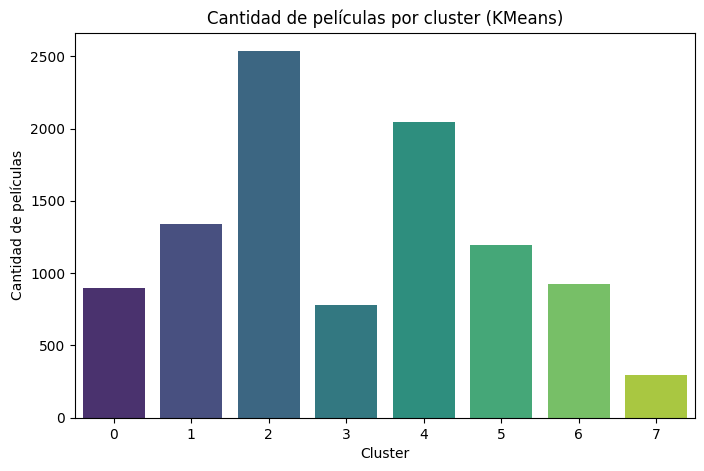

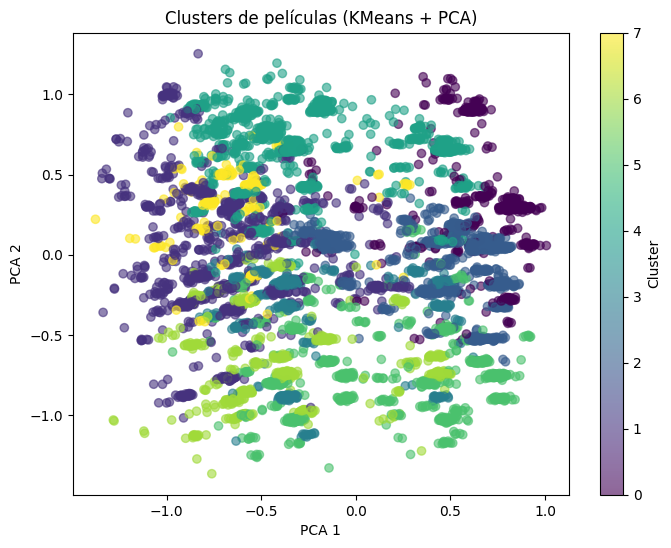

In [150]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

full_pipeline_kmeans = Pipeline([
    ('preprocessor', preprocesamiento),
    ('model', KMeans(n_clusters=8, random_state=42))
])

full_pipeline_kmeans.fit(df_movies_preprocesado)
labels = full_pipeline_kmeans.named_steps['model'].labels_
df_movies['Cluster'] = labels


# Conteo de películas por cluster
cluster_counts = df_movies['Cluster'].value_counts().sort_index()

plt.figure(figsize=(8,5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('Cantidad de películas por cluster (KMeans)')
plt.xlabel('Cluster')
plt.ylabel('Cantidad de películas')
plt.show()

X_cluster = full_pipeline_kmeans.named_steps['preprocessor'].transform(df_movies_preprocesado)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df_movies['Cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters de películas (KMeans + PCA)')
plt.colorbar(scatter, label='Cluster')
plt.show()



Gaussian Mixture Models (GMM)

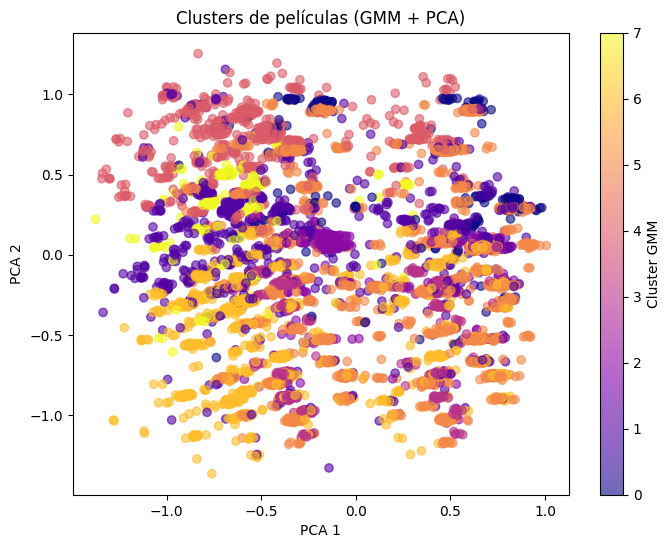

In [142]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Preprocesa los datos
X_cluster = preprocesamiento.transform(df_movies_preprocesado)

# Ajusta el modelo GMM
gmm = GaussianMixture(n_components=8, random_state=42)
gmm.fit(X_cluster)
labels_gmm = gmm.predict(X_cluster)
df_movies['Cluster_GMM'] = labels_gmm

# Reduce a 2 dimensiones para graficar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_gmm, cmap='plasma', alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters de películas (GMM + PCA)')
plt.colorbar(scatter, label='Cluster GMM')
plt.show()

Spectral Clustering

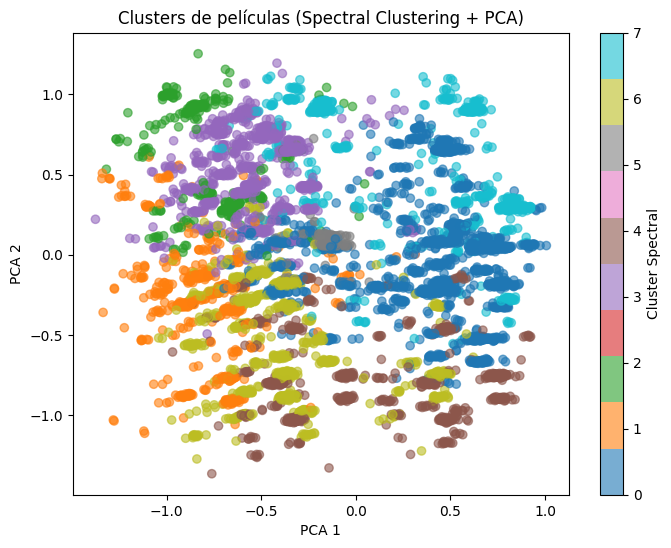

In [143]:
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Preprocesa los datos
X_cluster = preprocesamiento.transform(df_movies_preprocesado)

# Ajusta el modelo Spectral Clustering
spectral = SpectralClustering(n_clusters=8, random_state=42, assign_labels='kmeans')
labels_spectral = spectral.fit_predict(X_cluster)
df_movies['Cluster_Spectral'] = labels_spectral

# Reduce a 2 dimensiones para graficar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_spectral, cmap='tab10', alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters de películas (Spectral Clustering + PCA)')
plt.colorbar(scatter, label='Cluster Spectral')
plt.show()

K-Prototypes (mixto numérico + categórico)

In [145]:
df_movies_preprocesado

,Unnamed: 0,Film_title,Director,Average_rating,Runtime,Original_language,Description,Studios,Watches,List_appearances,...,Music,Mystery,Romance,Science Fiction,Show All…,Superheroes in action-packed battles with villains,TV Movie,Thriller,War,Western
0,0,The Fan,Eckhart Schmidt,3.570000,92.0,German,The hero-worship that Simone has for a pop sin...,Barbara Moorse Workshop,12841,11032,...,0,0,0,0,0,0,0,0,0,0
1,1,Mad Max: Fury Road,George Miller,4.180000,121.0,English,An apocalyptic story set in the furthest reach...,Warner Bros. Pictures|Village Roadshow Picture...,2488721,331681,...,0,0,0,1,0,0,0,0,0,0
2,2,Suspiria,Dario Argento,3.930000,99.0,English,An American newcomer to a prestigious German b...,Seda Spettacoli,618171,220094,...,0,0,0,0,0,0,0,0,0,0
3,3,Lost in Translation,Sofia Coppola,3.790000,102.0,English,"Two lost souls visiting Tokyo -- the young, ne...",American Zoetrope|Elemental Films,1596190,254180,...,0,0,1,0,0,0,0,0,0,0
4,4,Akira,Katsuhiro Otomo,4.280000,124.0,Japanese,A secret military project endangers Neo-Tokyo ...,MBS|Sumitomo Corporation|TOHO|Studio Fuga|Stud...,873068,175586,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9997,Evil Never Dies,Uli Edel,3.268535,205.0,English,"After his wife is brutally murdered, a policem...",Wolper Organization|Warner Bros. Television|TB...,108,163,...,0,0,0,0,0,0,1,1,0,0
9996,9998,The Master Butcher,Uli Edel,3.268535,176.0,German,"After his return from World War I, there is no...",Pakt Media|ARD|Moovie|ARD Degeto|SWR|Constanti...,227,84,...,0,0,0,0,0,0,1,0,0,0
9997,9999,Unterm Birnbaum,Uli Edel,3.268535,89.0,German,"After the death of their child, the Hradschek ...",mecom fiction|ARD,82,43,...,0,0,0,0,0,0,1,0,0,0
9998,10000,Simulant,April Mullen,2.260000,95.0,English,Faye attempts to replace her newly deceased hu...,Wango Films|Myriad Pictures|Particular Crowd|M...,4239,1135,...,0,0,0,1,0,0,0,1,0,0


In [146]:
import pandas as pd
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import MinMaxScaler

# 1. Cargar datos (asumo que ya lo tenés en df_movies)
df = df_movies.copy()

# 2. Separar tipos de variables
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categóricas:", categorical_features)
print("Numéricas:", numerical_features)

# 3. Escalar solo las numéricas (para que no dominen el clustering)
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# 4. Convertir categóricas a string (KPrototypes las requiere como object)
for col in categorical_features:
    df[col] = df[col].astype(str)

# 5. Aplicar KPrototypes
# Importante: categorical=[índices] debe contener las posiciones de las columnas categóricas
cat_idx = [df.columns.get_loc(col) for col in categorical_features]

kproto = KPrototypes(n_clusters=5, init='Cao', verbose=1, random_state=42)
clusters = kproto.fit_predict(df, categorical=cat_idx)

# 6. Guardar resultados
df_movies['Cluster'] = clusters
print(df_movies[['Film_title', 'Cluster']].head())


Categóricas: ['Film_title', 'Director', 'Genres', 'Original_language', 'Description', 'Studios', 'Genres_original', 'Studios_original']
Numéricas: ['Average_rating', 'Runtime', 'Watches', 'List_appearances', 'Likes', 'Fans', 'Lowest★', 'Medium★★★', 'Highest★★★★★', 'Total_ratings', 'desc_length', 'Sentiment', 'Cluster_GMM']
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 399, ncost: 30089.591128950626
Run: 1, iteration: 2/100, moves: 653, ncost: 28926.870816420327
Run: 1, iteration: 3/100, moves: 76, ncost: 28918.245659093365
Run: 1, iteration: 4/100, moves: 166, ncost: 28802.01821126484
Run: 1, iteration: 5/100, moves: 110, ncost: 28777.86393565313
Run: 1, iteration: 6/100, moves: 0, ncost: 28777.86393565313
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 235, ncost: 30182.0007246430

Varianza explicada por PC1 y PC2: [0.02481575 0.01842596]


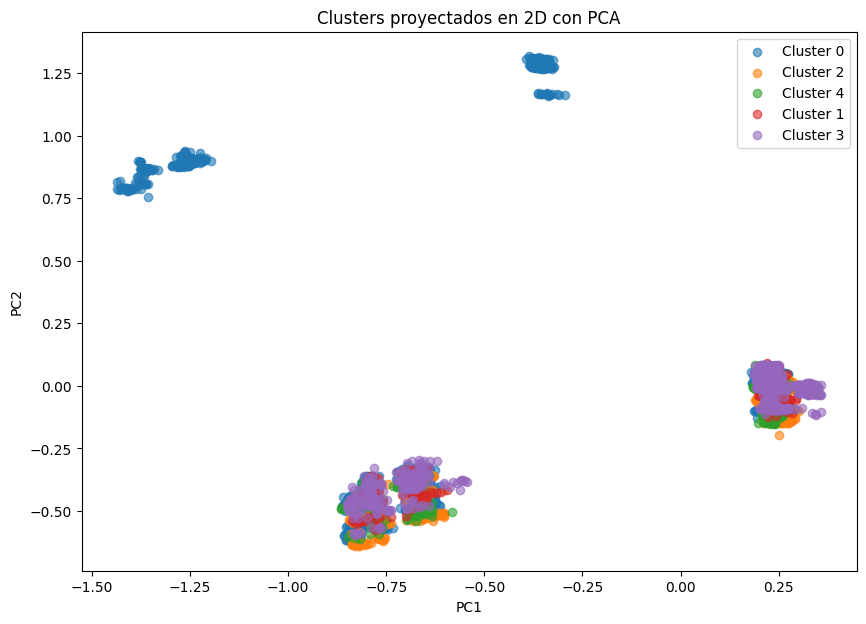

In [148]:
# --- 5. Para PCA necesitamos todo numérico -> aplicar OneHot a categóricas ---
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
categorical_encoded = encoder.fit_transform(df[categorical_features])

df_encoded = pd.DataFrame(
    categorical_encoded,
    index=df.index,
    columns=encoder.get_feature_names_out(categorical_features)
)

# Concatenamos numéricas + categóricas codificadas
df_numeric = pd.concat([df[numerical_features], df_encoded], axis=1)

# --- 6. PCA ---
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(df_numeric)

df_pca = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=df.index)
df_pca["Cluster"] = clusters

print("Varianza explicada por PC1 y PC2:", pca.explained_variance_ratio_)

# --- 7. Graficar ---
plt.figure(figsize=(10, 7))
for c in df_pca["Cluster"].unique():
    plt.scatter(
        df_pca[df_pca["Cluster"] == c]["PC1"],
        df_pca[df_pca["Cluster"] == c]["PC2"],
        label=f"Cluster {c}",
        alpha=0.6
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters proyectados en 2D con PCA")
plt.legend()
plt.show()

In [144]:
# K-Prototypes requiere instalar la librería kmodes
!pip install kmodes

from kmodes.kprototypes import KPrototypes
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Selecciona columnas numéricas y categóricas
numerical_cols = ['Runtime', 'Watches']  # ajusta según tus columnas numéricas
categorical_cols = ['Language_group', 'Director']  # ajusta según tus columnas categóricas

# Prepara los datos para K-Prototypes
X_kproto = df_movies_preprocesado[numerical_cols + categorical_cols].copy()
for col in categorical_cols:
    X_kproto[col] = X_kproto[col].astype(str)

# Convierte a numpy array
X_kproto_np = X_kproto.to_numpy()

# Indices de columnas categóricas
cat_cols_idx = [X_kproto.columns.get_loc(col) for col in categorical_cols]

# Ajusta el modelo K-Prototypes
kproto = KPrototypes(n_clusters=8, init='Cao', random_state=42)
clusters_kproto = kproto.fit_predict(X_kproto_np, categorical=cat_cols_idx)
df_movies['Cluster_KPrototypes'] = clusters_kproto

# Reduce a 2 dimensiones para graficar (solo numéricas)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_kproto[numerical_cols])

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_kproto, cmap='Accent', alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters de películas (K-Prototypes + PCA)')
plt.colorbar(scatter, label='Cluster K-Prototypes')
plt.show()


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


KeyError: "['Language_group'] not in index"

### Comparación de enfoques de clustering

En este trabajo se probaron tres enfoques principales para agrupar películas:

1. **K-Means**  
   - Separa los datos en clusters rígidos y bien definidos.  
   - Es rápido y fácil de interpretar, pero asume que los clusters son esféricos y homogéneos.  
   - Limita su capacidad de modelar películas híbridas (ej. acción + comedia).

2. **Gaussian Mixture Models (GMM)**  
   - Permite que cada película tenga una probabilidad de pertenencia a distintos clusters.  
   - Representa mejor la naturaleza difusa de las películas con géneros mixtos.  
   - Sin embargo, produce clusters más superpuestos y es más costoso computacionalmente.

3. **K-Prototypes**  
   - Extiende K-Means a datasets mixtos (variables numéricas y categóricas).  
   - Considera simultáneamente métricas cuantitativas (ej. número de visualizaciones, ratings) y cualitativas (ej. géneros, estudios).  
   - Genera clusters más interpretables y útiles para un recomendador, ya que combina popularidad con características propias del contenido.  

**Conclusión:**  
- K-Means sirve como un **baseline simple y rápido**.  
- GMM aporta **flexibilidad y probabilidades de pertenencia**, ideal si se busca capturar mezclas de géneros.  
- K-Prototypes ofrece un **balance más realista**, integrando tanto las variables numéricas como las categóricas, lo que lo convierte en el modelo más adecuado para construir un sistema de recomendación basado en similitudes completas entre películas.


# **Resultado: las 10 películas más recomendadas según el modelo**

Film_title → nombre de la película

Like_Probability → probabilidad predicha por la regresión logística de que al usuario le guste la película

In [ ]:
# # Ordenar por probabilidad descendente
# df_recommendations = df_movies.sort_values(by='Like_Probability', ascending=False)

# # Mostrar las 10 más recomendadas
# top_10 = df_recommendations[['Film_title', 'Like_Probability']].head(10)
# print(top_10)

# # Ordenar por rating predicho descendente
# df_recommendations = df_movies.sort_values(by='Predicted_Rating', ascending=False)

# # Mostrar las 10 más recomendadas
# top_10 = df_recommendations[['Film_title', 'Predicted_Rating']].head(10)
# print(top_10)

                      Film_title  Predicted_Rating
6560                  Duck Amuck          5.102627
6558                 Rabbit Fire          5.100138
6562           Hair-Raising Hare          5.099836
6554              Bully for Bugs          5.099526
6563            Robin Hood Daffy          5.099479
6589  The Abominable Snow Rabbit          5.098930
6600  My Bunny Lies Over the Sea          5.098841
6592                Bunny Hugged          5.098778
6599               Homeless Hare          5.098737
6551            Rabbit Seasoning          5.063794



**Reseña del Trabajo realizado**

El objetivo del trabajo fue desarrollar un sistema de recomendación de películas capaz de sugerir contenidos a un usuario según su perfil y las características de las películas. Para ello, se utilizó un dataset que incluía variables numéricas (como duración y presupuesto), categóricas (director, estudios, idioma) y multi-etiqueta (Genres), así como un target binario Likes indicando si al usuario le gustó la película.

Se construyó un pipeline de preprocesamiento que:

Imputa y escala automáticamente las variables numéricas,

Codifica las variables categóricas,

Convierte los géneros en columnas binarias (multi-label).

Luego, se entrenó un modelo de regresión logística que predice la probabilidad de que al usuario le guste cada película. Con estas probabilidades, se generó un ranking de recomendaciones, permitiendo identificar las películas más relevantes para el usuario. Este enfoque demuestra cómo integrar preprocesamiento avanzado con un modelo supervisado para crear un sistema de recomendación simple y escalable.